In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

In [109]:
np.random.seed(0)

In [67]:
class NIST36_Data(torch.utils.data.Dataset):
    def __init__(self, type):
        self.type = type
        self.data = sio.loadmat(f"../data/nist36_{type}.mat")
        self.inputs, self.one_hot_target = (
            self.data[f"{self.type}_data"],
            self.data[f"{self.type}_labels"],
        )
        print(self.one_hot_target.shape)
        self.target = np.argmax(self.one_hot_target, axis=1)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index):
        inputs = torch.from_numpy(self.inputs[index]).type(torch.float32)
        target = torch.tensor(self.target[index]).type(torch.LongTensor)
        return inputs, target

In [68]:
# Hyperparameters
batch_size = 64
learning_rate = 0.005
num_epochs = 100
hidden_size = 64
momentum = 0.9

In [ ]:
# Q6.1.1
class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.model = nn.Sequential(
            nn.Linear(1024, self.hidden_size),
            nn.Sigmoid(),
            nn.Linear(self.hidden_size, 36),
        )

    def forward(self, x):
        return self.model(x)

In [111]:
# Q6.1.2
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(16 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 36)
        )

    def forward(self, x):
        x = x.reshape(-1, 1, 32, 32)
        return self.model(x)

In [124]:
# Q6.1.3
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = x.reshape(-1, 3, 32, 32)
        return self.model(x)

In [70]:
##### Example usage #############
train_data = NIST36_Data(type="train")
valid_data = NIST36_Data(type="valid")
test_data = NIST36_Data(type="test")

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(10800, 36)
(3600, 36)
(1800, 36)


In [107]:
# Model, loss function, and optimizer
model = FullyConnectedNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [108]:
# Training loop
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
for epoch in range(num_epochs):
    model.train()
    train_acc, train_loss = 0, 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item()

    train_acc /= len(train_data)
    train_loss /= len(trainloader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation loop
    model.eval()
    valid_acc, valid_loss = 0, 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            valid_acc += (predicted == labels).sum().item()
            valid_loss += criterion(outputs, labels).item()
    
    valid_acc /= len(valid_data)
    valid_loss /= len(validloader)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
            

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

# Test loop
model.eval()
test_acc = 0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_acc += (predicted == labels).sum().item()

test_acc /= len(test_data)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1, Train Loss: 3.5686, Train Acc: 0.0452, Valid Loss: 3.5341, Valid Acc: 0.0750
Epoch 2, Train Loss: 3.4976, Train Acc: 0.1331, Valid Loss: 3.4459, Valid Acc: 0.2017
Epoch 3, Train Loss: 3.3905, Train Acc: 0.2286, Valid Loss: 3.3184, Valid Acc: 0.3039
Epoch 4, Train Loss: 3.2365, Train Acc: 0.2929, Valid Loss: 3.1458, Valid Acc: 0.3431
Epoch 5, Train Loss: 3.0512, Train Acc: 0.3585, Valid Loss: 2.9543, Valid Acc: 0.3847
Epoch 6, Train Loss: 2.8597, Train Acc: 0.4142, Valid Loss: 2.7637, Valid Acc: 0.4058
Epoch 7, Train Loss: 2.6737, Train Acc: 0.4477, Valid Loss: 2.5870, Valid Acc: 0.4569
Epoch 8, Train Loss: 2.4970, Train Acc: 0.4835, Valid Loss: 2.4234, Valid Acc: 0.5025
Epoch 9, Train Loss: 2.3370, Train Acc: 0.5108, Valid Loss: 2.2666, Valid Acc: 0.5128
Epoch 10, Train Loss: 2.1896, Train Acc: 0.5302, Valid Loss: 2.1342, Valid Acc: 0.5397
Epoch 11, Train Loss: 2.0594, Train Acc: 0.5543, Valid Loss: 2.0160, Valid Acc: 0.5467
Epoch 12, Train Loss: 1.9446, Train Acc: 0.5715, Val

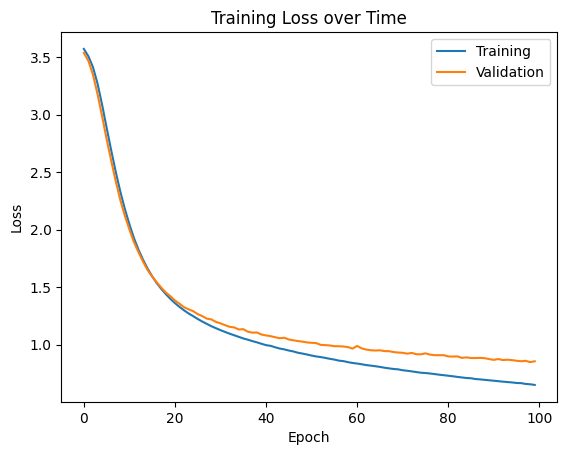

In [75]:
# Plot the loss curve
plt.plot(train_losses, label="Training")
plt.plot(valid_losses, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.show()

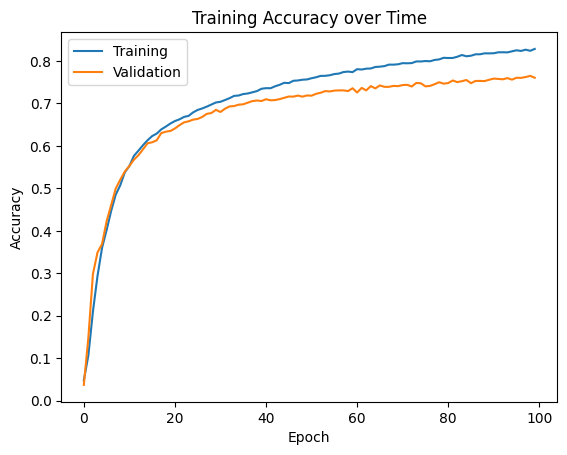

In [76]:
# Plot the accuracy curve
plt.plot(train_accs, label="Training")
plt.plot(valid_accs, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Time")
plt.show()

In [114]:
model = ConvNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [115]:
# Training loop
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
for epoch in range(30):
    model.train()
    train_acc, train_loss = 0, 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item()

    train_acc /= len(train_data)
    train_loss /= len(trainloader)
    train_losses.append(train_loss)
    
    train_accs.append(train_acc)

    # Validation loop
    model.eval()
    valid_acc, valid_loss = 0, 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            valid_acc += (predicted == labels).sum().item()
            valid_loss += criterion(outputs, labels).item()
    
    valid_acc /= len(valid_data)
    valid_loss /= len(validloader)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
            

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

# Test loop
model.eval()
test_acc = 0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_acc += (predicted == labels).sum().item()

test_acc /= len(test_data)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1, Train Loss: 3.5839, Train Acc: 0.0307, Valid Loss: 3.5791, Valid Acc: 0.0661
Epoch 2, Train Loss: 3.5762, Train Acc: 0.0361, Valid Loss: 3.5641, Valid Acc: 0.0428
Epoch 3, Train Loss: 3.5002, Train Acc: 0.0769, Valid Loss: 3.2812, Valid Acc: 0.1753
Epoch 4, Train Loss: 2.0969, Train Acc: 0.4282, Valid Loss: 1.2868, Valid Acc: 0.6211
Epoch 5, Train Loss: 1.0277, Train Acc: 0.6911, Valid Loss: 0.9092, Valid Acc: 0.7239
Epoch 6, Train Loss: 0.7749, Train Acc: 0.7657, Valid Loss: 0.7316, Valid Acc: 0.7814
Epoch 7, Train Loss: 0.6226, Train Acc: 0.8058, Valid Loss: 0.6052, Valid Acc: 0.8142
Epoch 8, Train Loss: 0.5053, Train Acc: 0.8421, Valid Loss: 0.6148, Valid Acc: 0.8061
Epoch 9, Train Loss: 0.4437, Train Acc: 0.8620, Valid Loss: 0.5405, Valid Acc: 0.8247
Epoch 10, Train Loss: 0.3744, Train Acc: 0.8832, Valid Loss: 0.4849, Valid Acc: 0.8508
Epoch 11, Train Loss: 0.3355, Train Acc: 0.8913, Valid Loss: 0.4665, Valid Acc: 0.8525
Epoch 12, Train Loss: 0.2936, Train Acc: 0.9043, Val

In [ ]:
plt.plot(train_losses, label="Training")
plt.plot(valid_losses, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.show()

In [ ]:
plt.plot(train_accs, label="Training")
plt.plot(valid_accs, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Time")
plt.show()

In [134]:
import torchvision
import torchvision.transforms as transforms

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [150]:
model = CIFAR10_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [151]:
# Training loop
train_losses, train_accs = [], []
test_losses, test_accs = [], []
for epoch in range(20):
    model.train()
    train_acc, train_loss = 0, 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item()

    train_acc /= len(trainset)
    train_loss /= len(trainloader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Test loop
    model.eval()
    test_acc, test_loss = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_acc += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()

    test_acc /= len(testset)
    test_loss /= len(testloader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1, Train Loss: 1.2921, Train Acc: 0.5389, Test Loss: 1.0311, Test Acc: 0.6303
Epoch 2, Train Loss: 0.8942, Train Acc: 0.6832, Test Loss: 0.8880, Test Acc: 0.6902
Epoch 3, Train Loss: 0.6967, Train Acc: 0.7553, Test Loss: 0.7956, Test Acc: 0.7238
Epoch 4, Train Loss: 0.5372, Train Acc: 0.8118, Test Loss: 0.8335, Test Acc: 0.7138
Epoch 5, Train Loss: 0.3783, Train Acc: 0.8686, Test Loss: 0.8504, Test Acc: 0.7274
Epoch 6, Train Loss: 0.2444, Train Acc: 0.9158, Test Loss: 0.9663, Test Acc: 0.7332
Epoch 7, Train Loss: 0.1479, Train Acc: 0.9509, Test Loss: 1.0949, Test Acc: 0.7289
Epoch 8, Train Loss: 0.0989, Train Acc: 0.9681, Test Loss: 1.2831, Test Acc: 0.7244
Epoch 9, Train Loss: 0.0837, Train Acc: 0.9721, Test Loss: 1.4169, Test Acc: 0.7257
Epoch 10, Train Loss: 0.0688, Train Acc: 0.9774, Test Loss: 1.4594, Test Acc: 0.7204
Epoch 11, Train Loss: 0.0577, Train Acc: 0.9805, Test Loss: 1.5151, Test Acc: 0.7233
Epoch 12, Train Loss: 0.0616, Train Acc: 0.9791, Test Loss: 1.5571, Test A

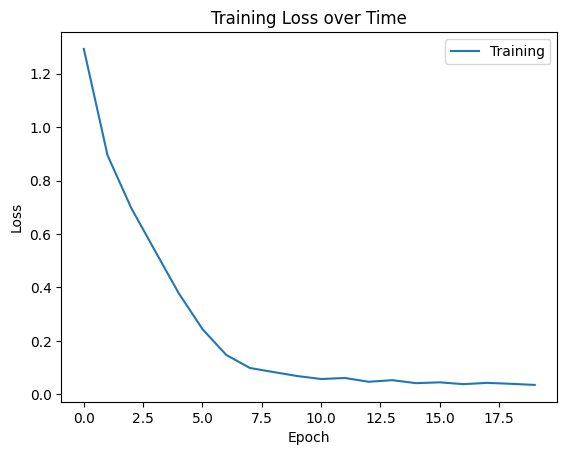

In [154]:
plt.plot(train_losses, label="Training")
# plt.plot(test_losses, label="Testing")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.show()

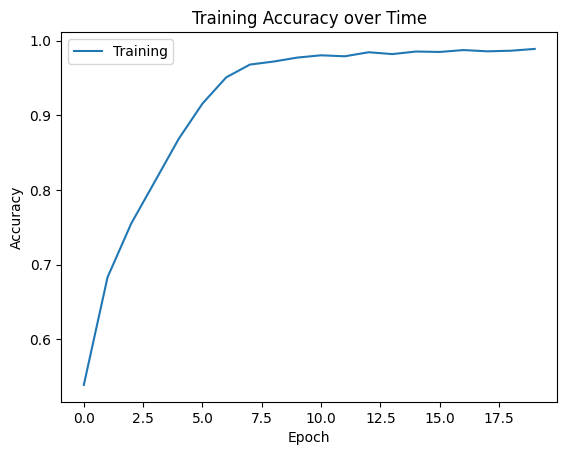

In [155]:
plt.plot(train_accs, label="Training")
# plt.plot(test_accs, label="Testing")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Time")
plt.show()